In [2]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import networkx as nx

import sys
sys.path.append("..")
sys.path.append("../d2c/")
from utils import print_dag, dag_to_formula, show_dag

import pickle

#suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score



In [3]:
# df = pd.read_csv('../data/ts3_descriptors_with_cycles.csv')  # replace with your data file
df = pd.read_csv('../data/ts5_descriptors_with_cycles.csv')  # replace with your data file
# df = pd.read_csv('../data/ts_limited_descriptors.csv')  # replace with your data file



In [4]:
df = df.drop_duplicates(subset=['graph_id', 'edge_source', 'edge_dest'], keep='first').reset_index(drop=True)

In [5]:
df.to_csv('../data/ts5_fixed_descriptors_with_cycles.csv', index=False)

In [6]:
graph_info = df[['graph_id','edge_source','edge_dest']]
X = df.drop(columns=['graph_id','edge_source','edge_dest', 'is_causal'])
y = df['is_causal']

In [7]:
#data stats
print('Number of samples:', len(X))
print('Number of features:', len(X.columns))
print('Number of causal edges:', y.sum())
print('Number of non-causal edges:', len(y) - y.sum())
print('Number of graphs:', len(df['graph_id'].unique()))


Number of samples: 45000
Number of features: 92
Number of causal edges: 7506
Number of non-causal edges: 37494
Number of graphs: 1500


In [8]:
X

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature82,Feature83,Feature84,Feature85,Feature86,Feature87,Feature88,Feature89,Feature90,Feature91
0,0.067796,-0.278205,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,74.614333,54.953306,8.021390,-6.115111,1.610458,2.093956,6.924163,29.032334
1,0.295755,0.491573,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,74.614333,47.240373,8.021390,3.299974,6.012510,5.909580,48.113067,63.583511
2,-1.349899,-0.639216,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,74.614333,-1.307289,8.021390,-5.958614,4.944538,-64.568580,-54.991321
3,-1.242661,-0.821586,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,54.953306,-1.307289,-6.115111,3.631621,-1.655760,-47.200093,-52.719084
4,-0.228380,-0.228380,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,71.318126,-1.307289,8.148340,-3.230397,8.093250,-39.795642,-23.885010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,-0.186399,-0.140454,0.027863,0.000126,0.000041,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,28.719160,23.782017,2.566904,0.261256,2.081316,0.140297,2.256394,-5.944817
44996,-0.129243,0.022077,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,36.426137,25.202182,-3.535397,2.978243,1.302877,1.697962,7.858334,2.893543
44997,0.254317,0.217834,0.060171,0.060171,0.024847,0.01921,0.01921,0.01921,0.01921,0.01921,...,6,0.039474,36.426137,36.455159,-3.535397,-5.574772,-2.869700,-5.365685,21.306027,26.227298
44998,-0.063341,-0.104350,0.057916,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,36.426137,23.782017,-3.535397,0.261256,-0.459624,1.196496,-11.115187,0.494992


In [9]:
with open('../data/ts5.pkl', 'rb') as f:
    observations, dags, updated_dags = pickle.load(f)

With Naive

In [10]:

#train test split 
logo = LeaveOneGroupOut()
groups = df['graph_id']
brf_scores = pd.DataFrame(columns=['accuracy_train','precision_train','recall_train', 'f1_train', 'auc_train', 'accuracy_test', 'precision_test', 'recall_test', 'f1_test', 'auc_test', 'accuracy_naive', 'precision_naive', 'recall_naive', 'f1_naive', 'auc_naive', 'accuracy_random', 'precision_random', 'recall_random','f1_random', 'auc_random'])
counter = 0
predicted_values = {}
predicted_probabilities = {}
real_values = {}
for train_index, test_index in logo.split(X, y, groups):
    current_group = groups[test_index[0]]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    brf = BalancedRandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, n_jobs=-1)
    brf.fit(X_train, y_train)



    accuracy_train = brf.score(X_train, y_train)
    precision_train = precision_score(y_train, brf.predict(X_train))
    recall_train = recall_score(y_train, brf.predict(X_train))
    f1_train = f1_score(y_train, brf.predict(X_train))
    auc_train = roc_auc_score(y_train, brf.predict_proba(X_train)[:,1])

    predicted_probs = brf.predict_proba(X_test)[:,1]
    threshold = 0.8  # for example
    predicted_labels = (predicted_probs > threshold).astype(int)

    # accuracy_test = brf.score(X_test, y_test)
    # precision_test = precision_score(y_test, brf.predict(X_test))
    # recall_test = recall_score(y_test, brf.predict(X_test))
    # f1_test = f1_score(y_test, brf.predict(X_test))
    # auc_test = roc_auc_score(y_test, brf.predict_proba(X_test)[:,1])

    accuracy_test = brf.score(X_test, y_test)
    precision_test = precision_score(y_test, predicted_labels)
    recall_test = recall_score(y_test, predicted_labels)
    f1_test = f1_score(y_test, predicted_labels)
    auc_test = roc_auc_score(y_test, brf.predict_proba(X_test)[:,1])

    naive_predictions = np.zeros(len(y_test))
    accuracy_naive = np.mean(naive_predictions == y_test)
    precision_naive = precision_score(y_test, naive_predictions)
    recall_naive = recall_score(y_test, naive_predictions)
    f1_naive = f1_score(y_test, naive_predictions)
    auc_naive = roc_auc_score(y_test, naive_predictions)

    random_predictions = np.random.randint(0,2,len(y_test))
    accuracy_random = np.mean(random_predictions == y_test)
    precision_random = precision_score(y_test, random_predictions)
    recall_random = recall_score(y_test, random_predictions)
    f1_random = f1_score(y_test, random_predictions)
    auc_random = roc_auc_score(y_test, random_predictions)

    

    predicted_values[len(brf_scores)] = brf.predict(X_test)
    predicted_probabilities[len(brf_scores)] = brf.predict_proba(X_test)[:,1]
    real_values[len(brf_scores)] = y_test

    brf_scores.loc[len(brf_scores)] = [accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test, accuracy_naive, precision_naive, recall_naive, f1_naive, auc_naive, accuracy_random, precision_random, recall_random, f1_random, auc_random]


    counter += 1
    if counter == 20:
        break

c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469

In [1]:
brf_scores

NameError: name 'brf_scores' is not defined

In [68]:
brf_scores_old = pd.read_csv('ts5_brf_scores.csv')

In [74]:
pd.concat([brf_scores_old['precision_test'],brf_scores['precision_test'],brf_scores_old['recall_test'],brf_scores['recall_test'] ],axis=1)

,precision_test,precision_test,recall_test,recall_test
0,0.500000,1.000000,1.000000,1.000000
1,0.500000,1.000000,1.000000,1.000000
2,0.450000,0.875000,1.000000,0.777778
3,0.500000,0.750000,1.000000,0.750000
4,0.500000,1.000000,1.000000,1.000000
5,0.500000,0.833333,1.000000,0.833333
6,0.428571,0.666667,1.000000,0.666667
7,0.545455,0.833333,0.857143,0.714286
8,0.416667,0.833333,1.000000,1.000000
9,0.555556,0.500000,1.000000,0.600000


In [17]:
predicted_values

{0: array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0], dtype=int64),
 1: array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0], dtype=int64),
 2: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1], dtype=int64),
 3: array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0], dtype=int64),
 4: array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0], dtype=int64),
 5: array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 6: array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0], dtype=int64),
 7: array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 8: arra

In [11]:
all_labels = np.concatenate([real_values[i] for i in real_values.keys()])
all_probs = np.concatenate([predicted_probabilities[i] for i in predicted_probabilities.keys()])

In [12]:
pre_postprocessing = pd.concat([graph_info, pd.DataFrame(all_labels, columns=['predicted_label']), pd.DataFrame(all_probs, columns=['predicted_probabilities'])], axis=1).head(600)

In [13]:
pre_postprocessing.to_csv('ts5_pre_postprocessing.csv', index=False)

In [14]:
data = pd.read_csv('ts5_pre_postprocessing.csv')
# Iterate over the rows of the dataframe
for idx, row in data.iterrows():
    # If the edge (i,j) is predicted as causal
    if row['predicted_label'] == 1:
        # Find the row with the edge (j,i)
        reverse_edge = data[(data['edge_source'] == row['edge_dest']) & 
                            (data['edge_dest'] == row['edge_source'])]
        
        # If the edge (j,i) is also predicted as causal
        if not reverse_edge.empty and reverse_edge.iloc[0]['predicted_label'] == 1:
            # Compare their probabilities
            if row['predicted_probabilities'] < reverse_edge.iloc[0]['predicted_probabilities']:
                # Set the label and probability of (i,j) to 0
                data.at[idx, 'predicted_label'] = 0
                data.at[idx, 'predicted_probabilities'] = 0
            else:
                # Set the label and probability of (j,i) to 0
                data.at[reverse_edge.index[0], 'predicted_label'] = 0
                data.at[reverse_edge.index[0], 'predicted_probabilities'] = 0

# Display the updated data
data.head()


,graph_id,edge_source,edge_dest,predicted_label,predicted_probabilities
0,0,1,2,1.0,0.917537
1,0,1,5,1.0,0.951670
2,0,0,1,0.0,0.000269
3,0,0,2,0.0,0.000269
4,0,0,3,0.0,0.000269


In [15]:
data['truth'] = y.head(600)

In [48]:

#handle a single graph
graph_id = 5

info = graph_info.loc[graph_info['graph_id'] == graph_id]
pred_causes = predicted_values[graph_id]
pred_probs = predicted_probabilities[graph_id]
real_causes = real_values[graph_id].values

In [49]:
info

,graph_id,edge_source,edge_dest
150,5,0,3
151,5,0,4
152,5,1,0
153,5,1,3
154,5,5,1
155,5,5,2
156,5,0,1
157,5,0,2
158,5,0,5
159,5,1,2


In [59]:

results = pd.concat([info.reset_index(drop=True), pd.DataFrame(pred_causes, columns=['pred_causes']), pd.DataFrame(real_causes, columns=['real_causes']),pd.DataFrame(pred_probs, columns=['predicted_probabilities'])], axis=1)
results.sort_values(by=['edge_source','edge_dest'], ascending=True)


,graph_id,edge_source,edge_dest,pred_causes,real_causes,predicted_probabilities
6,5,0,1,1,0,0.795077
7,5,0,2,0,0,0.000000
0,5,0,3,1,1,0.895926
1,5,0,4,1,1,0.945887
8,5,0,5,0,0,0.000000
2,5,1,0,1,1,0.709968
9,5,1,2,0,0,0.000362
3,5,1,3,1,1,0.869633
10,5,1,4,0,0,0.000000
11,5,1,5,1,0,0.812605


In [51]:
for sources in results.edge_source.unique():
    for dest in results.edge_dest.unique():
        fragment_1 = results.loc[ (results['edge_source'] == sources) & (results['edge_dest'] == dest)]
        fragment_2 = results.loc[ (results['edge_source'] == dest) & (results['edge_dest'] == sources)]
        print(fragment_1)
        break

   graph_id  edge_source  edge_dest  pred_causes  real_causes  \
0         5            0          3            1            1   

   predicted_probabilities  
0                 0.895926  
   graph_id  edge_source  edge_dest  pred_causes  real_causes  \
3         5            1          3            1            1   

   predicted_probabilities  
3                 0.869633  
    graph_id  edge_source  edge_dest  pred_causes  real_causes  \
28         5            5          3            0            0   

    predicted_probabilities  
28                      0.0  
    graph_id  edge_source  edge_dest  pred_causes  real_causes  \
14         5            2          3            0            0   

    predicted_probabilities  
14                      0.0  
Empty DataFrame
Columns: [graph_id, edge_source, edge_dest, pred_causes, real_causes, predicted_probabilities]
Index: []
    graph_id  edge_source  edge_dest  pred_causes  real_causes  \
25         5            4          3            0

In [52]:
results.to_csv('temp_results.csv')

In [53]:

results = pd.read_csv('temp_results.csv')

In [54]:


#construct dag from pred_causes
import sys
sys.path.append("..")
sys.path.append("../d2c/")
from utils import print_dag, dag_to_formula, show_dag
import numpy as np
import pandas as pd
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(np.unique(np.append(results.edge_source.unique(),results.edge_dest.unique())))

for value in results.iterrows():
    if value[1]['pred_causes'] == 1:
        G.add_edge(int(value[1]['edge_source']), int(value[1]['edge_dest']), color='blue', weight=value[1]['predicted_probabilities'])




In [55]:
print_dag(G)

####################
Node 0 has attributes {}
Node 1 has attributes {}
Node 2 has attributes {}
Node 3 has attributes {}
Node 4 has attributes {}
Node 5 has attributes {}
Edge 0 -> 3 has attributes {'color': 'blue', 'weight': 0.895926104457865}
Edge 0 -> 4 has attributes {'color': 'blue', 'weight': 0.9458868432054732}
Edge 0 -> 1 has attributes {'color': 'blue', 'weight': 0.7950765006639956}
Edge 1 -> 0 has attributes {'color': 'blue', 'weight': 0.7099676337568385}
Edge 1 -> 3 has attributes {'color': 'blue', 'weight': 0.8696334739850962}
Edge 1 -> 5 has attributes {'color': 'blue', 'weight': 0.8126054531029329}
Edge 2 -> 5 has attributes {'color': 'blue', 'weight': 0.6739090734497597}
Edge 3 -> 0 has attributes {'color': 'blue', 'weight': 0.7050748633169814}
Edge 3 -> 1 has attributes {'color': 'blue', 'weight': 0.698808188531125}
Edge 4 -> 0 has attributes {'color': 'blue', 'weight': 0.7200914981503537}
Edge 5 -> 1 has attributes {'color': 'blue', 'weight': 0.8133118455604602}
Edge 5

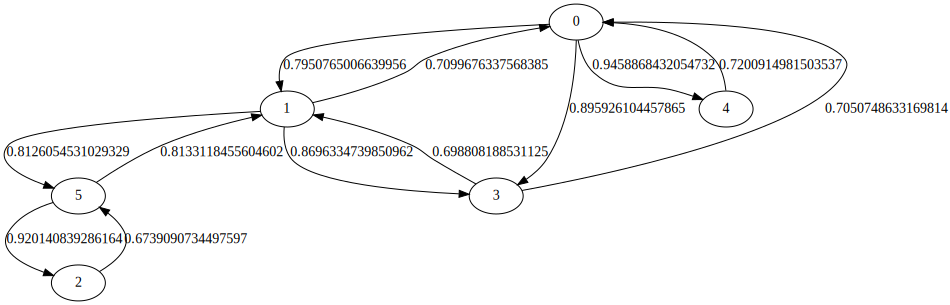

In [56]:

show_dag(G)


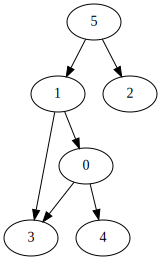

In [57]:
show_dag(dags[graph_id],weight=False)